In [7]:
# In this cell, you just experiment with the environment, playing randomly
import gym
env = gym.make('Blackjack-v0')

for i_episode in range(3):
    state = env.reset()
    while True:
        print(state)
        action = env.action_space.sample()
        state, reward, done, info = env.step(action)
        if done:
            print('End game! Reward: ', reward)
            print('You won :)\n') if reward > 0 else print('You lost :(\n')
            break

(14, 4, False)
End game! Reward:  -1.0
You lost :(

(17, 5, True)
End game! Reward:  1.0
You won :)

(8, 3, False)
(18, 3, False)
End game! Reward:  -1
You lost :(



Episode 50000/50000.

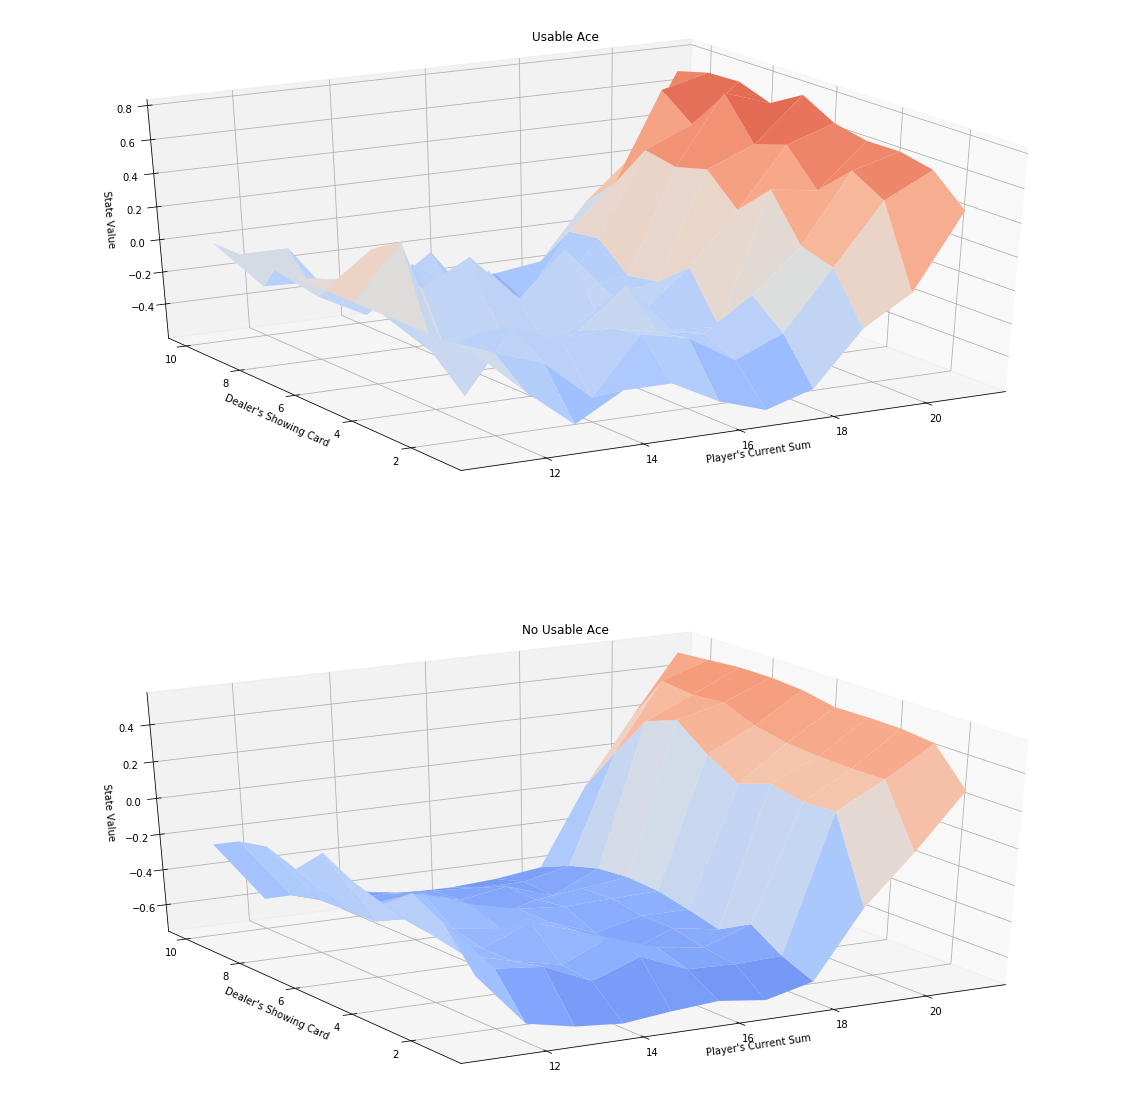

In [6]:
# In this cell you have routines for estimating the State-Value function Q
import sys
import gym
import numpy as np
from collections import defaultdict
from plot_utils import plot_blackjack_values, plot_policy
%matplotlib inline

def generate_episode_from_limit_stochastic(bj_env):
    episode = []
    state = bj_env.reset()
    while True:
        probs = [0.8, 0.2] if state[0] > 18 else [0.2, 0.8]
        action = np.random.choice(np.arange(2), p=probs)
        next_state, reward, done, info = bj_env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

def mc_prediction_q(env, num_episodes, generate_episode, gamma=1.0):
    # initialize empty dictionaries of arrays
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        ## TODO: complete the function
        episode = generate_episode(env)
        #print(f"episode length: {len(episode)}")
        for i_iteration in range(len(episode)):
            state = episode[i_iteration][0]
            action = episode[i_iteration][1]
            reward = episode[-1][2]
            N[state][action] += 1
            returns_sum[state][action] += reward
            Q[state][action] = returns_sum[state][action]/N[state][action]
            #print(f"iteration no: {i_iteration}")
        
    return Q

env = gym.make('Blackjack-v0')

# obtain the action-value function
Q = mc_prediction_q(env, 50000, generate_episode_from_limit_stochastic)

# obtain the corresponding state-value function
V_to_plot = dict((k,(k[0]>18)*(np.dot([0.8, 0.2],v)) + (k[0]<=18)*(np.dot([0.2, 0.8],v))) \
         for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V_to_plot)

Episode 10000/10000.

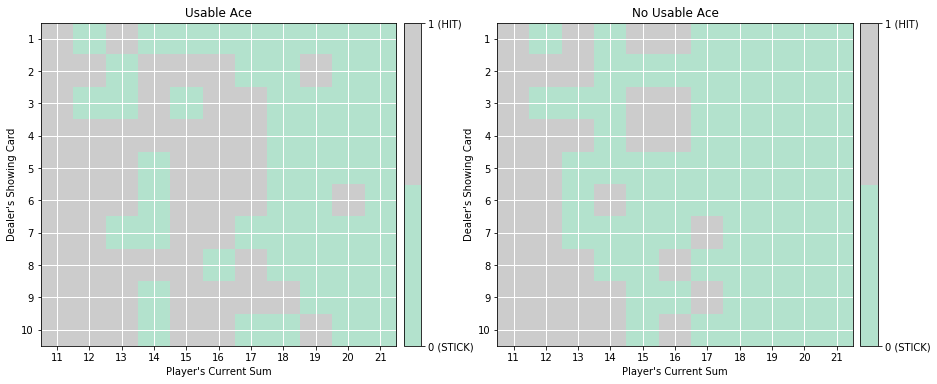

In [4]:
# This cell has Monte Carlo Control implemented, which is,
# finding the approximate optimal policy by Monte Carlo
import sys
import gym
import numpy as np
from collections import defaultdict
from plot_utils import plot_blackjack_values, plot_policy
%matplotlib inline

def policy_in_diff_e_greedy(Q, state, epsilon):
    """This policy first tests if the state argument is present (in) the Q dictiony.
    Secondly, it tests if the value of choosing actions 0 or 1 are diferent.
    Thirdly, it tests if the greedy_choice was drawn.
    In case all 3 conditions are met, then the greedy action is selected.
    Otherwise, if any condition fails, an equiprobable random action is selected."""
    #epsilon = 0.10
    if state in Q:
        if Q[state][0] != Q[state][1]:
            greedy_choice = np.random.choice([True, False], p=[1-epsilon, epsilon])
            if greedy_choice:
                action = np.argmax(Q[state])
            else:
                action = env.action_space.sample()
        else:
            action = env.action_space.sample()
    else:
        action = env.action_space.sample()
    return action

def generate_episode(bj_env, policy, Q, epsilon):
    episode = []
    state = bj_env.reset()
    while True:
        action = policy(Q, state, epsilon)
        next_state, reward, done, info = bj_env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

def mc_control_constant_alpha(env, num_episodes, alpha, epsilon=0.1, gamma=1.0):
    
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        episode = generate_episode(env, policy_in_diff_e_greedy, Q, epsilon)
        for i_iteration in range(len(episode)):
            state = episode[i_iteration][0]
            action = episode[i_iteration][1]
            reward = episode[-1][2]
            Q[state][action] = (1-alpha)*Q[state][action] + alpha*reward
    
    policydict = defaultdict(lambda: 0)
    for state in Q:
        policydict[state] = np.argmax(Q[state])
    
    return policydict, Q

env = gym.make('Blackjack-v0')

# obtain the estimated optimal policy and action-value function
#policy, Q = mc_control(env, ?, ?)
# mc_control_constant_alpha(env, num_episodes, alpha, epsilon=0.1, gamma=1.0):
policy, Q = mc_control_constant_alpha(env, 10000, 0.023, 0.05)

# plot the policy
plot_policy(policy)